In [1]:
from Code.Outils import *
from Code.Metriques import *
from sklearn import datasets
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from random import *
from statistics import *
from sklearn.metrics import *

## Extraction des données

In [2]:
iris = datasets.load_iris()

https://en.wikipedia.org/wiki/Iris_flower_data_set

In [3]:
#iris.target_names --- 0 = setosa, 1=versicolor, 2= viriginica
#iris.feature_names --- sepal length, width, petal length, i=width

In [4]:
Data = iris["data"]

In [5]:
Data.shape

(150, 4)

## Application du k-means

In [6]:
np.array([[0,1],[2,6]]).mean(axis=0)

array([1. , 3.5])

In [7]:
def k_means(K,data,max_iter,function_initial_centers):
    """
    Renvoie un tuple contenant:
    - la liste des centres de chaque cluster
    - label contenant les clusters correspondants de chaque points
    chaque liste est associé à la valeur du numéro du cluster auquel il correspond 
    """
    centroid = []
    cluster_not_the_same = True
    c = 0
    IVC = []
    

    # Calcul du centre aléatoire    
    centroid = function_initial_centers(K,data)
  
    # Tant que la condition d'arrêt n'est pas respecté 
    while(c!=max_iter and cluster_not_the_same):
        # Remise à zéro de clusters
        cluster = dict((i,[]) for i in range(K))
        c += 1
        label = []
        
        #Assignation des points en fonction de leurs clusters
        for point in data:
            # Aucun cluster n'est assigné au point
            clust = (None,float('inf')) # (numéro du cluster,distance au cluster)
            #Choix du cluster
            for i in range(K):
                dist = np.linalg.norm(point-centroid[i])
                #Si le centre du cluster est plus proche que ceux étudiés avant nous le remplaçons
                if dist<clust[1]:
                    clust = (i,dist)
            
            cluster[clust[0]].append(point)
            label.append(clust[0])
        
        # Recalcule les centres
        new_centroid = [np.mean(cluster[i],axis=0) for i in range(K)]
        # Calcul de l'intra variance cluster pour itération
        IVC.append(IVC_Kmeans(centroid,cluster))
        
        # On regarde si les centres sont toujours les mêmes
        if (np.array_equal(new_centroid,centroid)): 
            cluster_not_the_same= False
        else:
            centroid=new_centroid
        
    
    return (centroid,cluster,label,[i for i in range(1,len(IVC)+1)],IVC)

In [8]:
mean_centroid(3,Data)

[array([5.006, 3.428, 1.462, 0.246]),
 array([5.936, 2.77 , 4.26 , 1.326]),
 array([6.588, 2.974, 5.552, 2.026])]

## Résultats des données

In [9]:
acc_test = []
rd_test = []
rd = []
rd_adj = []
rd_adj_test = []
for exp in range(4):
    seed(exp)
    _,_,label,_,_ = k_means(3,Data,100,mean_centroid)
    kmeans = KMeans(n_clusters=3,random_state=exp,max_iter=100).fit(Data)
    acc_test.append(Accuracy(kmeans.labels_,label))
    rd_test.append(rand_index(kmeans.labels_,label))
    rd.append(rand_score(kmeans.labels_,label))
    rd_adj.append(adjusted_rand_score(kmeans.labels_,label))
    rd_adj_test.append(Adjusted_Rand_Index(kmeans.labels_,label))

### Rand index

In [10]:
mean(rd_test),pstdev(rd_test)

(0.9911409395973154, 0.0)

In [11]:
mean(rd),pstdev(rd)

(0.9911409395973154, 0.0)

### Adjusted Rand Index

In [12]:
mean(rd_adj),pstdev(rd_adj)

(0.980280739387653, 0.0)

In [13]:
mean(rd_adj_test),pstdev(rd_adj_test)

(0.980280739387653, 0.0)

### Accuracy

In [14]:
mean(acc_test),pstdev(acc_test)

(0.6883333333333334, 0.17609183210283585)

### Intra variance cluster

In [15]:
_,_,_,X,Y = k_means(3,Data,100,mean_centroid)

Text(0, 0.5, 'IVC')

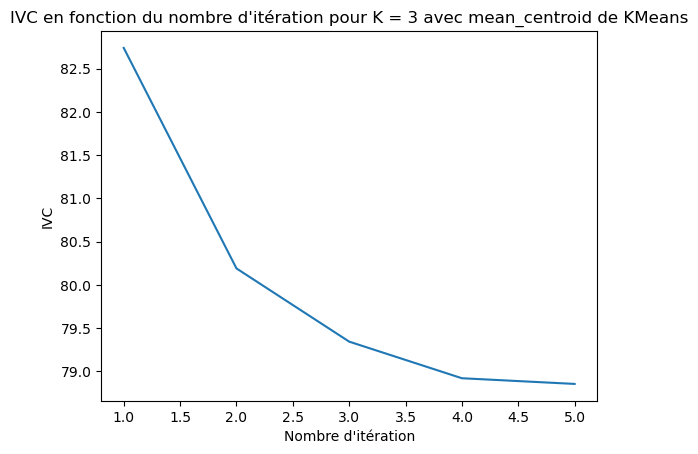

In [16]:
plt.plot(X,Y)
plt.title("IVC en fonction du nombre d'itération pour K = 3 avec mean_centroid de KMeans")
plt.xlabel("Nombre d'itération")
plt.ylabel("IVC")

In [17]:
seed(0)
_,_,_,X,Y = k_means(2,Data,100,random_centers)

In [18]:
X,Y

([1, 2, 3, 4, 5, 6],
 [940.5297561171442,
  295.0512923449496,
  204.01645864939388,
  157.6393962962963,
  152.51316676847566,
  152.34795176035792])

Text(0, 0.5, 'IVC')

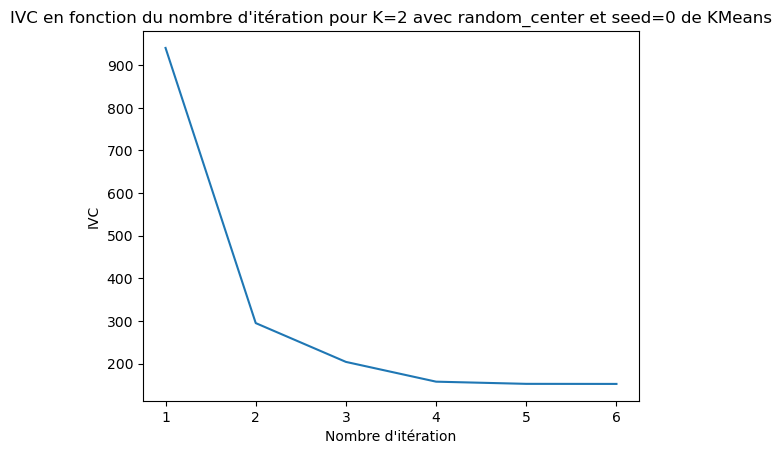

In [19]:
plt.plot(X,Y)
plt.title("IVC en fonction du nombre d'itération pour K=2 avec random_center et seed=0 de KMeans")
plt.xlabel("Nombre d'itération")
plt.ylabel("IVC")

Text(0, 0.5, 'IVC')

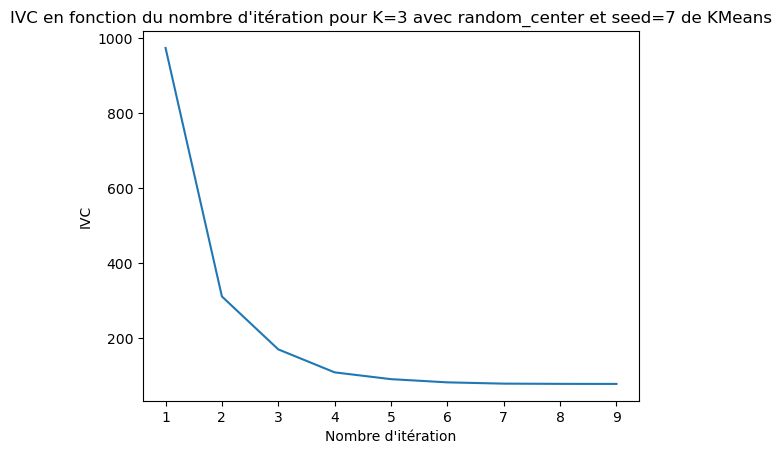

In [20]:
seed(7)
_,_,_,X,Y = k_means(3,Data,100,random_centers)
plt.plot(X,Y)
plt.title("IVC en fonction du nombre d'itération pour K=3 avec random_center et seed=7 de KMeans")
plt.xlabel("Nombre d'itération")
plt.ylabel("IVC")

In [21]:
Y,X

([974.8300640641448,
  312.0440592026122,
  170.9547848875661,
  109.67485523067265,
  91.54995620057875,
  83.02104835746147,
  79.61572102298426,
  79.01204896074461,
  78.85144142614601],
 [1, 2, 3, 4, 5, 6, 7, 8, 9])

In [22]:
Y = []
for k in range(1,10):
    _,_,_,_,X = k_means(k,Data,15,mean_centroid)
    Y.append(X[-1])

Text(0, 0.5, 'IVC')

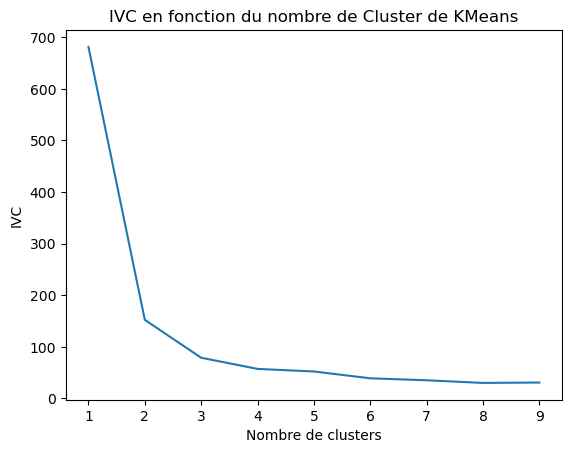

In [23]:
plt.plot([i for i in range(1,len(Y)+1)],Y)
plt.title("IVC en fonction du nombre de Cluster de KMeans")
plt.xlabel("Nombre de clusters")
plt.ylabel("IVC")

### Silhouette

In [24]:
def silhouette(cluster,label,distance):
    s = 0
    sc = 0
    for c in range(len(cluster)):
        for i in cluster[c]:
            ai = sum([distance(i,cluster[c][a]) for a in range(len(cluster[c]))])/(len(cluster[c])-1)
            bi = []
            for oc in range(len(cluster)): 
                if c!=oc :
                    bi.append(sum([distance(i,cluster[oc][b]) for b in range(len(cluster[oc]))])/len(cluster)) 
            sc = (min(bi)-ai)/max(ai,min(bi))
        s = s + sc/len(cluster[c])
    return s/len(cluster)    

In [25]:
cent,clust,lab,_,_ = k_means(3,Data,100,random_centers)
print("my silhouette : ", silhouette(clust,lab,lambda x,y : np.linalg.norm(x-y)))
print("Silhouette librairie",silhouette_score(Data,lab))

my silhouette :  0.02014177092479499
Silhouette librairie 0.5528190123564095
